Load Jupyter modules

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\dorasir\anaconda3\envs\net-simu\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


Load Python modules

In [2]:
import numpy as np
import os
from sklearn.metrics import average_precision_score, roc_auc_score
import pandas as pd
from utils.transformation import clr_transform, alr_transform
from matplotlib import pyplot as plt
from itertools import product
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from utils import simulation
import rpy2.robjects as robjects
import seaborn as sns
from utils.generalized_lotka_volterra import GeneralizedLotkaVolterra
from utils.compositional_lotka_volterra import CompositionalLotkaVolterra
from scipy.stats import ttest_rel
import utils.evaluations as ev
from utils.evaluations import correlation_score, precision_matrix_score, clv_score, glv_score, pcor_score, sparcc_score, speic_score, baseline_score
from typing import List
import seaborn as sns
from utils.transformation import clr_transform, alr_transform

# Make sure the working directory is correct
os.chdir('d:\\microbial_network\\microbial_network_explore')

In [3]:
# Define function for evaluation
def evaluation(adj, abundance, evaluation_func, metrics=average_precision_score, verbose=False):
    scores = []
    for func in evaluation_func:
        scores.append([func._method, *func(abundance, adj, metrics=metrics, verbose=verbose)])
    columns = ['Method']
    columns.extend([metric.__name__ for metric in metrics] if isinstance(metrics, List) else [metrics.__name__])
    scores_df = pd.DataFrame(scores, columns=columns)
    return scores_df

Set up the parameters for the first simulation

In [9]:
# Set up parameters
n_vertices = 5
avg_degree = 2
network_type = 'random'
interaction_type = 'random'
time_points = 1000
time_step = 0.01
downsample = 1
noise_var = 1e-3

evaluation_func = [correlation_score, precision_matrix_score, clv_score, glv_score, pcor_score, sparcc_score, speic_score, baseline_score]
metrics = [average_precision_score, roc_auc_score]

In [10]:
%%capture
result_df = pd.DataFrame(columns=["Method", "run", "average_precision_score", "roc_auc_score", "abs_rel"])
repeat = 10
# Setup the random seed generator
rng = np.random.default_rng(42)

for i in range(repeat):
    seed = rng.integers(0, 2**32 - 1)
    z, x, abd, adj, M = simulation.simulate_glv(
        num_taxa=n_vertices,
        avg_degree=avg_degree,
        time_points=time_points,
        time_step=time_step,
        downsample=1,
        noise_var=0,
        seed=seed,
    )
    score_df = evaluation(adj, z, evaluation_func, metrics=metrics, verbose=False)
    score_df["run"] = i
    score_df["abs_rel"] = "Absolute"
    result_df = result_df.append(score_df, ignore_index=True)

    score_df = evaluation(adj, abd, evaluation_func, metrics=metrics, verbose=False)
    score_df["run"] = i
    score_df["abs_rel"] = "Relative"
    result_df = result_df.append(score_df, ignore_index=True)


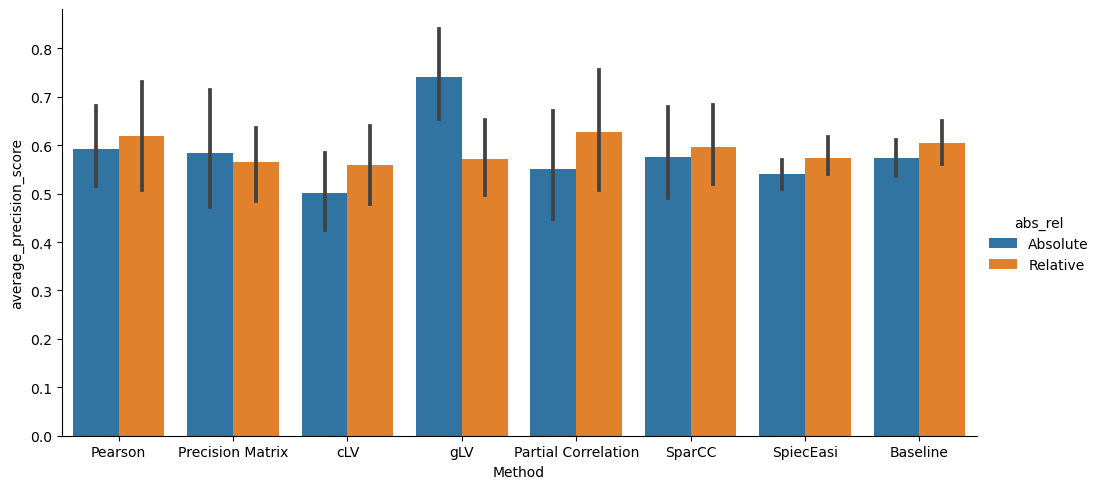

In [11]:
sns.catplot(data=result_df, x='Method', y='average_precision_score', hue='abs_rel', kind='bar', height=5, aspect=2)

In [12]:
from statannotations.Annotator import Annotator

In [15]:
methods = result_df.Method.unique()
# pairs = list(product(result_df.Method.unique(), result_df.Method.unique()))

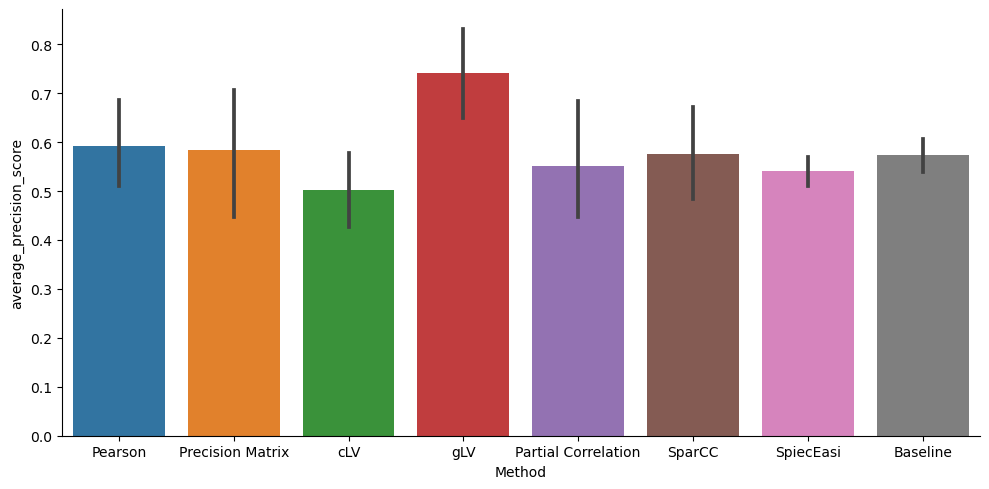

In [13]:
sns.catplot(data=result_df[result_df['abs_rel']=='Absolute'], x='Method', y='average_precision_score', kind='bar', height=5, aspect=2)


In [16]:
print('a')

a
